In [1]:
using LinearAlgebra, DiffEqSensitivity, Optim
using DifferentialEquations
using Plots
using FFTW
using DSP
using JLD
gr()

Plots.GRBackend()

In [this paper](http://dx.doi.org/10.1103/PhysRevE.79.061921), the feedback parameters were $(v, r) = (\sqrt{\alpha}, 0.4)$. In [this other paper](http://dx.doi.org/10.1103/PhysRevE.83.041920), they use $(v, r) = (0.0014\sqrt{\alpha}, 0.71)$ in one simulation but at one point search over $\alpha \in [3, 7]$. They find bistability (i.e. multiple fundamental frequencies are possible with the same parameters depending on initial conditions) for some $\alpha$ in that range, so maybe best to stay away from high values of $\alpha$ for now. 

[This implementation](https://github.com/zekearneodo/syrinxsynth/blob/3c0968af2b8cbefad164171a8353404f0e6dad68/syrinxsynth/dynamo/finch.py#L89) using the normal form version of the model (like we do) appears to just use $(v, r) = (1, 0)$, i.e. no coupling, but honestly [both open implementations](https://github.com/kylerbrown/mindlin_auto/blob/31f7688bb4b0d6eb4e4ec704f249be9356cae1fe/finch_void.c) of this model are basically unreadable so I'm not 100% sure.

I'm just gonna go with $(v, r) = (\sqrt{\alpha}, 0.4)$ for now. Neither paper really justified its parameters in a convincing way, anyway.

In [2]:
function glottis!(du, u, h, p, t)

    # unpack parameters
    α, β, γ, τ = p # subglottal pressure, laryngeal tension, time constant, delay
    
    # constant feedback coefficients
    v = sqrt(α) # proportional to mean velocity of airflow, always positive
    r = 0.4 # reflection coefficient, always in range [0, 1]

    # unpack variables
    x, y, P = u # opening of glottis, its derivative, and pressure entering tract
    
    # source-tract coupling term is from http://dx.doi.org/10.1103/PhysRevE.83.041920
    # but rest of dx/dt is from https://doi.org/10.1038/nature11967
    du[1] = y # (normal form vocal fold position dynamics) + (STC term)
    du[2] = (-α*γ^2 - β*γ^2*x - γ^2*x^3 - γ*x^2*y + γ^2*x^2 - γ*x*y) + γ*P*(γ - y)
    
    # (derivative of) input pressure of the tract P = vx - rP(t- τ)
    du[3] = v*y - r*h(p, t - τ, Val{1})[3]

end

p = [.1, .1, 2600, 0.001] # default parameters
h(p, t, ::Type{Val{1}}) = zeros(3) # disapatch for t < tspan[0]
u0 = Float64[0., 0., 0.] # initial conditions for x, y, P
tspan = (0, 1.0) # timespan to simulate 
prob = DDEProblem(glottis!, u0, h, tspan, p); # that's it!

In [3]:
Fs = 48000 # sampling rate of simulated audio
times = 0:(1/Fs):1

# using solver with automatic stiffness detection
function predict(θ, X = u0, times = 0:(1/Fs):1)
    Array(solve(prob, MethodOfSteps(AutoVern6(Rosenbrock23())), 
                u0 = X, p = θ, 
                tspan = (times[1], times[end]), 
                saveat = times,
                sensealg = ForwardDiffSensitivity(),
                force_dtmin = true
                )[3,:])
end

function simulate_tract(α, β, γ, L)
    c = 34300 # speed of sound in cm/sec
    τ = 2 * L/c # coupling delay
    predict([α, β, γ, τ])
end

function compute_spectrum(x, fs = Fs)
    # returns the square magnitude spectrum of the input signal
    x .* hanning(length(x))
    F = fft(x) |> fftshift
    psd = abs.(F)
    freqs = FFTW.fftfreq(length(x), fs) |> fftshift
    speech_range = (0 .< freqs) .& (freqs .<= 3000)
    freqs[speech_range], psd[speech_range].^2
end

compute_spectrum (generic function with 2 methods)

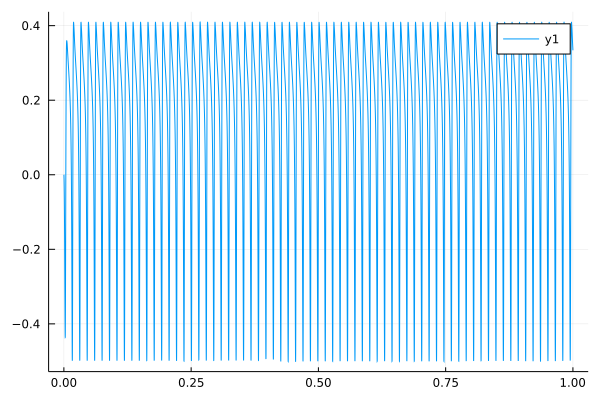

In [4]:
# length of vocal tract in cm is b/w 13-20 cm in adults
x = simulate_tract(.3, .3, 1000, 13)
plot(times, x)

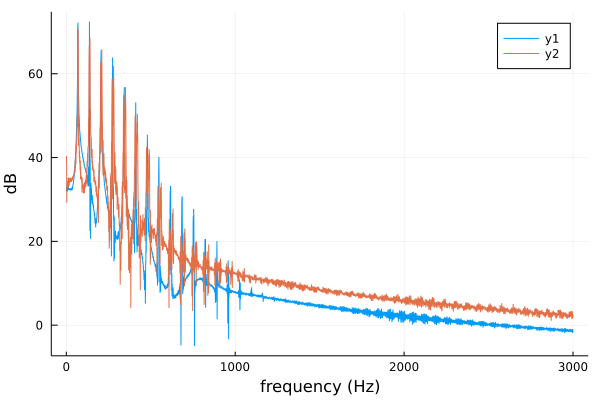

In [5]:
freqs, psd_x = compute_spectrum(x)
y = simulate_tract(.3, .3, 1000, 20)
freqs, psd_y = compute_spectrum(y)
plot(freqs, 10*log10.(psd_x), xlabel = "frequency (Hz)", ylabel = "dB")
plot!(freqs, 10*log10.(psd_y))
#savefig("coupling.png")

In [6]:
#save("length13.jld", "data", x)
#save("length20.jld", "data", y)